<center>
    <h3>Arnaud Chéridi</h3>
    <p>Étudiant en Master 2 Mathématiques Appliquées</p>
    <p>Projet individuel : Modélisation du risque de crédit (cas IFRS 9)</p>
    <p>Objectif : développer un modèle de PD (score > 65%) + LGD + simulation</p>
</center>

<center><h2> 4. Simulation de l'Exposition au moment du défaut <h2><center>

## Contexte

Après avoir sélectionné et calibré des modèles pour estimer les probabilités de défaut (`PD`) et les pertes en cas de défaut (`LGD`) à partir d’un jeu de données crédit, nous poursuivons notre analyse du risque de crédit en simulant trois grandeurs fondamentales dans le cadre de la norme IFRS 9 :

- **EAD (Exposure at Default)** : Exposition attendue au moment du défaut, c’est-à-dire le montant encore dû au moment où le client fait défaut.
- **EAC (Expected Annualized Cost)** : Perte attendue ponctuelle à un instant donné, calculée sur les flux de remboursement mensuels.
- **ECL (Expected Credit Loss)** : Perte attendue totale si le défaut survient à un instant donné, en tenant compte de l’ensemble de l’encours restant.

Ces simulations s’inscrivent dans une logique prospective de type "lifetime expected loss" et permettent de mieux quantifier l’évolution du risque dans le temps.

---

## Objectifs

L’objectif de cette étape est de :

- Simuler, **mois par mois**, la dynamique du portefeuille de crédits,
- Reproduire l'entrée en défaut aléatoire des clients, basée sur leur `PD`,
- Calculer à chaque pas de temps :
  - l’**EAD** : somme des encours restants des clients **au moment où ils font défaut**,
  - l’**EAC** : perte attendue instantanée, calculée comme `PD × LGD × remboursement_mensuel`,
  - l’**ECL** : perte attendue totale, calculée comme `PD × LGD × encours restant` pour chaque client actif,
- Répéter ce processus via une **simulation Monte Carlo**, pour obtenir une estimation robuste de l’évolution dans le temps du risque,
- Visualiser l’incertitude par une **moyenne et une bande de confiance** autour des trajectoires.

---

## Méthodologie

1. **Initialisation** :
   - On duplique le dataset original, en ajoutant des colonnes `defaulted` (booléen), `mois_defaut` (entier), `ead_defaut` (float).

2. **Simulation temporelle (mois par mois)** :
   - Chaque mois, pour chaque client encore actif :
     - On tire un uniforme $U \sim \mathcal{U}(0,1)$,
     - Si $U < \text{PD}$, le client entre en **défaut** à ce mois.
   - On marque les défauts et on les exclut des mois suivants.

3. **Calcul des indicateurs** :
   - `EAD(t)` : somme des montants encore dus par les clients **ayant fait défaut** à $t$,
   - `EAC(t)` : somme des pertes attendues sur les **flux mensuels** (encore actifs),
   - `ECL(t)` : somme des pertes attendues sur les **encours restants** (encore actifs), i.e. $PD \times LGD \times EAD(t)$.
   >**Hypothèse simplificatrice** : les simulations sont réalisées **hors taux d’intérêt**. On suppose que les remboursements mensuels et les encours ne sont pas actualisés. Cela revient à considérer une approximation en valeur nominale des flux.

4. **Monte Carlo (N simulations)** :
   - Le processus est répété $N$ fois (par exemple $N = 1000$),
   - À chaque itération, on stocke `EAD(t)`, `EAC(t)`, et `ECL(t)` sur l’horizon de simulation,
   - On extrait ensuite la **moyenne**, l’**écart-type**, et les **bandes de confiance**.

---

## Résultat attendu

Les graphiques finaux permettent de visualiser :
- L’évolution moyenne de l’**exposition au risque** (`EAD`),
- Le **coût du risque mensuel** (`EAC`), et la **perte attendue totale** (`ECL`) dans le temps,
- L’impact de l’aléa de défaut sur les flux futurs,
- L’incertitude du portefeuille via les bandes $\pm 2\sigma$ autour de la moyenne.

---

> Ces simulations permettent de mieux anticiper les pertes attendues sur un portefeuille de crédits, d’affiner le provisionnement IFRS 9, et de structurer des exercices de stress testing ou d’allocation de capital économique.

## 0. Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import joblib

## 1. Chargement des données et des modèles

In [2]:
train_final = pd.read_csv("data/train_final.csv")
test_final = pd.read_csv("data/test_final.csv")
full_df = pd.concat([train_final, test_final], axis=0)

df = full_df.drop(columns=["TARGET", "SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])

model_pd = joblib.load("model_pd.pkl")
model_lgd = joblib.load("model_lgd.pkl")

## 2. Calcul de la PD et de LGD avec nos modèles et calcul

In [3]:
df["PD"] = model_pd.predict_proba(df)[:,1]
df["LGD"] = model_lgd.predict(df.drop(columns=["PD"]))

/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


- `duree_credit_mois` : estimation de la **durée du crédit en mois**, en supposant que le montant total des revenus sert à rembourser l'annuité.
- `remboursement_mensuel` : estimation du **montant mensuel remboursé**

In [4]:
df["duree_credit_mois"] = (df["AMT_INCOME_TOTAL"]/df["AMT_ANNUITY"]*12).astype(int)
df["remboursement_mensuel"] = df["AMT_ANNUITY"]/12

Dans le dataset, la variable `PD` représente la **probabilité cumulée de défaut sur toute la durée du crédit**, c’est-à-dire la probabilité qu’un client fasse défaut à un moment quelconque avant la fin de son contrat.

Pour simuler le risque **mois par mois** dans un cadre dynamique (ex : simulation de défauts ou de flux en Monte Carlo), nous devons convertir cette probabilité globale en une **probabilité conditionnelle de défaut par période mensuelle**.

La formule utilisée est issue de l’hypothèse d’indépendance temporelle des défauts :
$\text{PD}_{\text{mensuelle}} = 1 - (1 - \text{PD}_{\text{totale}})^{1 / \text{durée\_mois}}$

Cette relation suppose que la probabilité de **survie jusqu'à la fin du crédit** est égale au produit des probabilités de survie à chaque mois, ce qui revient à répartir le risque de manière constante dans le temps.

>**Remarque** : Cette transformation est couramment utilisée lorsque l’on simule des événements de défaut de manière itérative dans le temps (ex : tirages mensuels avec une loi uniforme).

In [5]:
def convertir_pd_mensuelle(pd_totale, duree_mois):
    return 1 - (1 - pd_totale)**(1 / duree_mois)

# Application vectorielle
df["pd_mensuelle"] = convertir_pd_mensuelle(df["PD"], df["duree_credit_mois"])

> Les prédictions de LGD sont bornées entre 0 et 1 à l’aide de la méthode `.clip()`, afin de respecter la définition économique de la LGD comme taux de perte compris entre 0 % et 100 %.

In [6]:
df["LGD"] = df["LGD"].clip(lower=0.0, upper=1.0)

## 3. Mise en place des planchers

Les planchers suivants sont appliqués conformément aux exigences **réglementaires (IFRS 9 / Bâle II/III)** :

- **Probabilité de défaut minimale (PD)** :
  - *Cash loans* : 0.05 % (`0.0005`)
  - *Revolving loans* : 0.10 % (`0.001`)

- **Loss Given Default minimale (LGD)** :
  - *Cash loans* : 15 % (`0.15`)
  - *Revolving loans* : 70 % (`0.70`)

Ces **valeurs minimales** sont imposées pour éviter une sous-estimation excessive du risque de crédit.

In [7]:
plancher_pd = {
    'Cash loans': 0.0005,       # 0.05%
    'Revolving loans': 0.001    # 0.10%
}

plancher_lgd = {
    'Cash loans': 0.15,         # 15%
    'Revolving loans': 0.70     # 70%
}

In [8]:
# Fonction d'ajustement des valeurs plancher
def appliquer_planchers(row):
    type_credit = row['NAME_CONTRACT_TYPE']
    row['PD'] = max(row['PD'], plancher_pd.get(type_credit, 0))
    row['LGD'] = max(row['LGD'], plancher_lgd.get(type_credit, 0))
    return row

# Application au DataFrame
df = df.apply(appliquer_planchers, axis=1)

## 4. Simulation de l'EAC, l'EAD et l'ECL

## Objectif de la simulation Monte Carlo

L’objectif de cette simulation est d’estimer dynamiquement l’évolution des indicateurs de risque liés à un portefeuille de crédits, en tenant compte de l’incertitude de défaut. Plus précisément, on calcule à chaque pas de temps :

- **l’EAD au moment du défaut** : `ead_defaut_montecarlo`
- **la perte attendue mensuelle (EAC)** : `eac_montecarlo`
- **la perte attendue totale (ECL)** : `ecl_montecarlo`
- **l’encours encore actif** dans le portefeuille : `encours_total_montecarlo`

Le processus est répété **M = 1000 fois** (simulation de Monte Carlo), mois par mois, jusqu’à la durée maximale observée (`temps_max`).

---

### Déroulé d’une simulation unique

À chaque simulation, on répète la procédure suivante :

- Pour chaque client encore actif :
  - On **tire un uniforme** $U \sim \mathcal{U}(0,1)$,
  - Si $U < \text{PD}$, le client **entre en défaut** ce mois-ci,
  - On enregistre alors :
    - Le **mois du défaut**
    - L’**exposition au moment du défaut** :
      $\text{EAD}_i(t) = (\text{durée restante}) \times \text{remboursement mensuel}$

- Pour chaque mois \( t \), on calcule :

  - **EAD au défaut** :
    $\text{EAD}_t = \sum_{\text{clients en défaut à } t} \text{EAD}_i(t)$

  - **EAC (perte attendue sur flux)** :
    $\text{EAC}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{remboursement mensuel}_i$

  - **ECL (perte attendue sur encours)** :
    $\text{ECL}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{EAD théorique}_i(t)$

  - **Encours vivant** :
    $\text{Encours}_t = \sum_{\text{clients actifs}} \text{durée restante} \times \text{remboursement mensuel}$


---

> Ces données sont ensuite agrégées (moyenne, quantiles) sur les 100 (afin de limiter les coûts computationnels) simulations afin de visualiser l’évolution moyenne, la volatilité et les scénarios extrêmes du risque de crédit dans le portefeuille.

In [9]:
def simulation_montecarlo(temps_max):
    df_sim = df.copy()
    df_sim["defaulted"] = False
    df_sim["mois_defaut"] = np.nan
    df_sim["ead_defaut"] = 0.0

    ead_defaut_vec = np.zeros(temps_max)   # Réalisé (clients qui font défaut à t)
    eac_vec = np.zeros(temps_max)          # Espérance sur flux
    ecl_vec = np.zeros(temps_max)          # Espérance sur encours
    encours_vec = np.zeros(temps_max)      # Encours restant du

    for mois in range(temps_max):
        # Clients encore actifs
        actifs = df_sim[(~df_sim["defaulted"]) & (df_sim["duree_credit_mois"] > mois)]

        # Tirage aléatoire : simulation de défaut
        tirages = np.random.uniform(0, 1, len(actifs))
        defaut = tirages < actifs["pd_mensuelle"].values
        index_defaut = actifs[defaut].index

        # Marquer les défauts
        df_sim.loc[index_defaut, "defaulted"] = True
        df_sim.loc[index_defaut, "mois_defaut"] = mois

        # Calcul de l’EAD au défaut pour les clients défaillants à t
        ead_defaut = ((df_sim.loc[index_defaut, "duree_credit_mois"] - mois) *
                      df_sim.loc[index_defaut, "remboursement_mensuel"])
        df_sim.loc[index_defaut, "ead_defaut"] = ead_defaut
        ead_defaut_vec[mois] = ead_defaut.sum()

        # EAC = PD × LGD × mensualité (espérance sur flux)
        eac_mois = (actifs["pd_mensuelle"] * actifs["LGD"] * actifs["remboursement_mensuel"]).sum()
        eac_vec[mois] = eac_mois

        # ECL = PD × LGD × EAD théorique (espérance sur encours restant)
        ead_theorique = (actifs["duree_credit_mois"] - mois) * actifs["remboursement_mensuel"]
        ecl_mois = (actifs["pd_mensuelle"] * actifs["LGD"] * ead_theorique).sum()
        ecl_vec[mois] = ecl_mois

        # Encours restant dû pour les clients encore actifs
        encours_mois = ((actifs["duree_credit_mois"] - mois) * actifs["remboursement_mensuel"]).sum()
        encours_vec[mois] = encours_mois

    return ead_defaut_vec, eac_vec, ecl_vec, encours_vec

In [10]:
N = 100  # nombre de simulations
temps_max = 60 # horizon max

results = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(simulation_montecarlo)(temps_max) for _ in range(N))

ead_defaut_montecarlo = np.array([res[0] for res in results])
eac_montecarlo = np.array([res[1] for res in results])
ecl_montecarlo = np.array([res[2] for res in results])
encours_montecarlo = np.array([res[3] for res in results])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.8s
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:  5.1min remaining:   34.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


In [11]:
# Moyenne et bande ±2σ
ead_mean = ead_defaut_montecarlo.mean(axis=0)
ead_std = ead_defaut_montecarlo.std(axis=0)

eac_mean = eac_montecarlo.mean(axis=0)
eac_std = eac_montecarlo.std(axis=0)

ecl_mean = ecl_montecarlo.mean(axis=0)
ecl_std = ecl_montecarlo.std(axis=0)

encours_mean = encours_montecarlo.mean(axis=0)
encours_std = encours_montecarlo.std(axis=0)

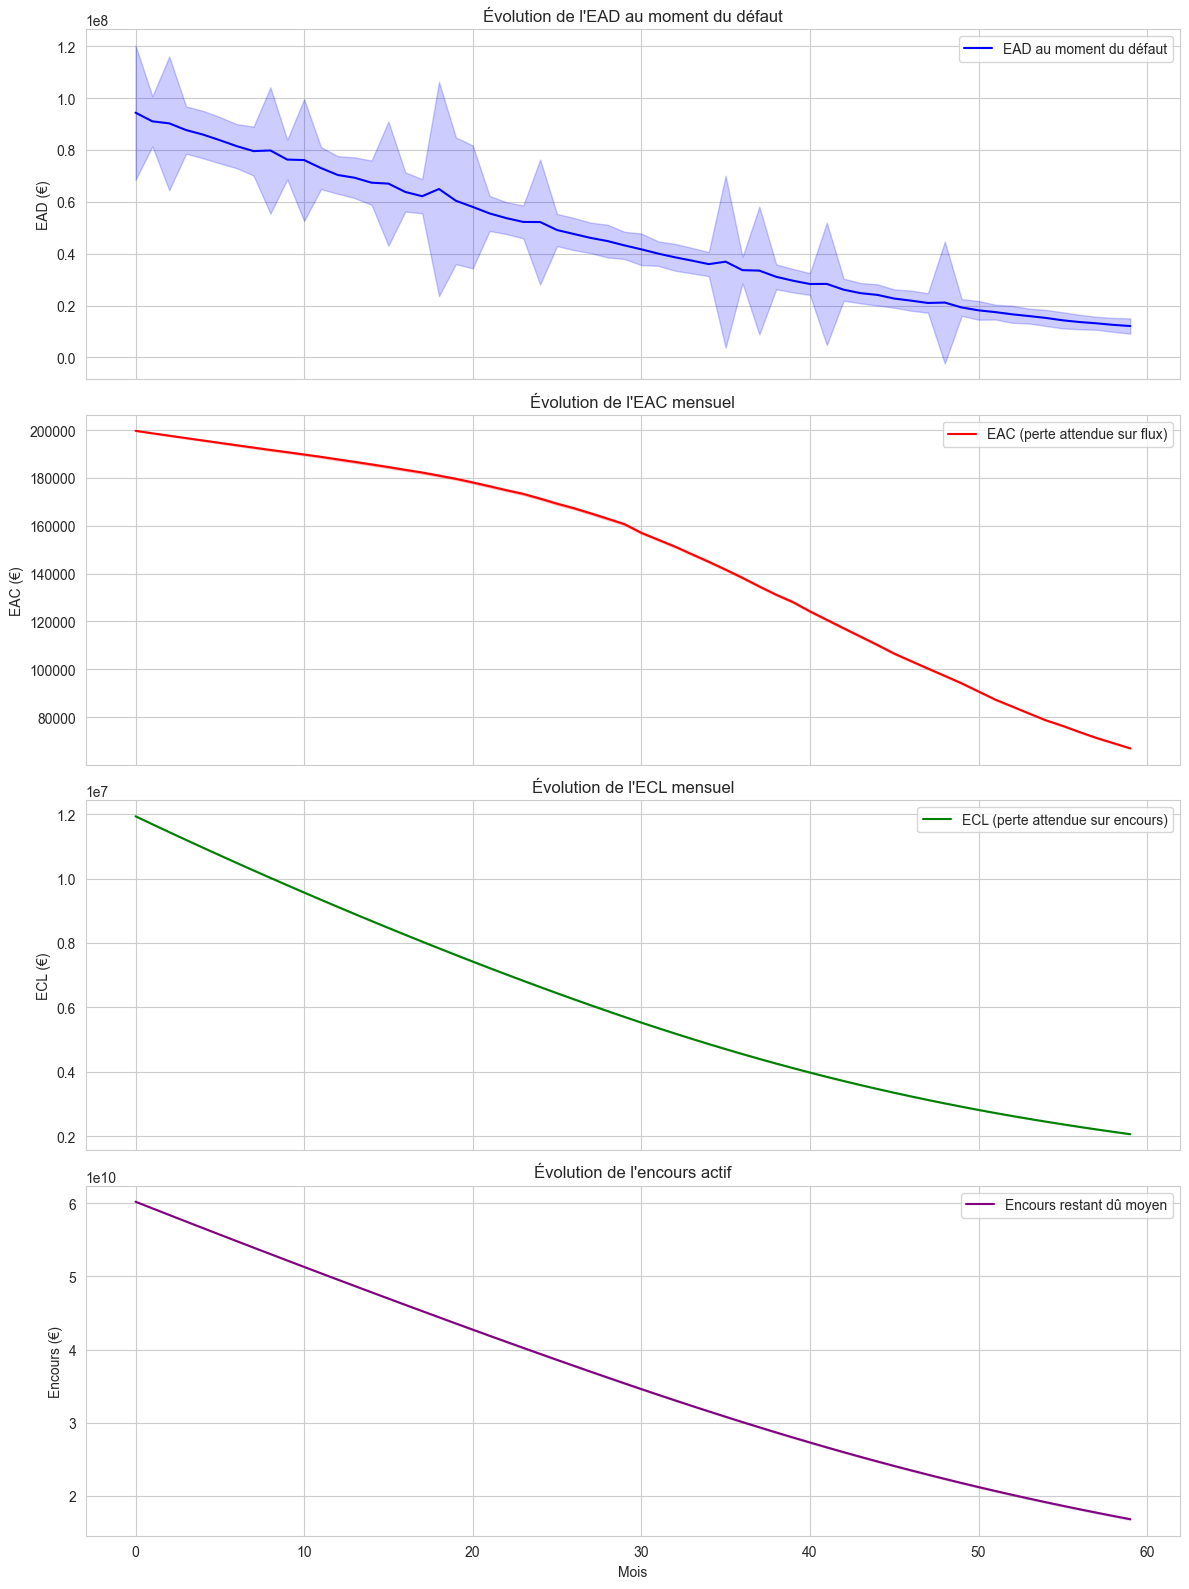

In [12]:
# Création du subplot (4 lignes désormais)
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# --- EAD au défaut
axes[0].plot(ead_mean, label="EAD au moment du défaut", color='blue')
axes[0].fill_between(range(temps_max), ead_mean - 2*ead_std, ead_mean + 2*ead_std, alpha=0.2, color='blue')
axes[0].set_ylabel("EAD (€)")
axes[0].set_title("Évolution de l'EAD au moment du défaut")
axes[0].legend()
axes[0].grid(True)

# --- EAC
axes[1].plot(eac_mean, label="EAC (perte attendue sur flux)", color='red')
axes[1].fill_between(range(temps_max), eac_mean - 2*eac_std, eac_mean + 2*eac_std, alpha=0.2, color='red')
axes[1].set_ylabel("EAC (€)")
axes[1].set_title("Évolution de l'EAC mensuel")
axes[1].legend()
axes[1].grid(True)

# --- ECL
axes[2].plot(ecl_mean, label="ECL (perte attendue sur encours)", color='green')
axes[2].fill_between(range(temps_max), ecl_mean - 2*ecl_std, ecl_mean + 2*ecl_std, alpha=0.2, color='green')
axes[2].set_ylabel("ECL (€)")
axes[2].set_title("Évolution de l'ECL mensuel")
axes[2].legend()
axes[2].grid(True)

# --- Encours restant dû
encours_mean = encours_montecarlo.mean(axis=0)
encours_std = encours_montecarlo.std(axis=0)

axes[3].plot(encours_mean, label="Encours restant dû moyen", color='purple')
axes[3].fill_between(range(temps_max), encours_mean - 2*encours_std, encours_mean + 2*encours_std, alpha=0.2, color='purple')
axes[3].set_ylabel("Encours (€)")
axes[3].set_xlabel("Mois")
axes[3].set_title("Évolution de l'encours actif")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

## Analyse des résultats simulés – Monte Carlo (100 trajectoires)

Les graphiques ci-dessous présentent l’évolution moyenne de quatre indicateurs clés de la modélisation du risque de crédit, simulés sur 100 trajectoires Monte Carlo :

- l’**EAD au moment du défaut** (bleu),
- l’**EAC mensuel** (rouge),
- l’**ECL mensuel** (vert),
- l’**encours restant dû** (violet).

---

### 1. Évolution de l’EAD au moment du défaut

- L’**exposition au moment du défaut** décroît dans le temps, passant de ~110M€ à moins de 20M€ après 60 mois.
- La courbe décroît globalement de manière **quasi-linéaire**, avec quelques fluctuations dues à l’aléa du défaut (bandes bleues).
- Cela reflète le fait que **moins de clients restent exposés** au fil du temps, car certains remboursent, d’autres font défaut.

**💡 Interprétation** : le risque de défaut porte sur un encours décroissant, ce qui réduit mécaniquement l’exposition moyenne en cas de défaut.

---

### 2. Évolution de l’EAC (Expected Accrued Cost)

- L’**EAC mensuel** chute progressivement, partant d’environ 200 000 € à moins de 90 000 €.
- Cela reflète la **perte attendue sur les flux mensuels**, proportionnelle à `PD × LGD × remboursement`.

**💡 Interprétation** : cette décroissance lente reflète la disparition progressive des crédits actifs (portefeuille fermé) et donc des flux à risque.

---

### 3. Évolution de l’ECL (Expected Credit Loss)

- L’ECL, représentant la **perte attendue sur encours**, suit une courbe descendante allant de ~12M€ à moins de 3M€.
- Il traduit la **valeur actuelle du risque de crédit résiduel** en cas de défaut immédiat.

**💡 Interprétation** : l’encours pondéré par le risque diminue dans le temps, reflétant la réduction progressive du portefeuille et la sélection des emprunteurs les plus solides.

---

### 4. Évolution de l’encours actif

- L’**encours restant dû** passe de 6 milliards € à ~1,2 milliard € en 60 mois.
- Cette décroissance linéaire illustre l’amortissement progressif des crédits (effet combiné des remboursements et des défauts).

**💡 Interprétation** : le portefeuille est fermé (pas de nouveaux prêts), ce qui explique la réduction mécanique de l'encours dans le temps.

---

## Interprétation économique globale

Ces résultats confirment un comportement classique dans un portefeuille de crédit :

- Le **risque est concentré en début de vie** du contrat,
- Les défauts interviennent souvent tôt, sur des encours importants,
- L’EAC baisse rapidement, signalant la diminution du flux à risque,
- L’ECL reste significatif plus longtemps, car l’encours total amortit lentement.

> **Remarque** : Pour aller plus loin, une approche enrichie aurait consisté à **intégrer une structure de taux d’intérêt**, par exemple à partir des **courbes de l’Euribor** fournies par les économistes. Cela aurait permis :
> - de **modéliser la dépendance temporelle** de la `PD` et de la `LGD` vis-à-vis des conditions de marché,
> - d’**interpoler les taux aux dates des contrats**, si celles-ci avaient été disponibles,
> - puis de **simuler des scénarios économiques** à l’aide de modèles stochastiques (comme le **modèle CIR** ou **Vasicek**) pour produire des **trajectoires de taux cohérentes** sur différents horizons temporels.
### Implications pour la gestion du risque :

- Les banques doivent **provisionner fortement en début de crédit** (exigence IFRS 9 Stage 1),
- Il est crucial d’**anticiper les pertes attendues sur encours et flux** dès l’octroi,
- L’analyse dynamique du risque permet une **meilleure planification du capital** à risque et des buffers prudentiels.